# Setup

In [359]:
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum as oe
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint

from quant_rotor.core.sparse.hamiltonian import hamiltonian_sparse
from quant_rotor.core.dense.hamiltonian import hamiltonian_dense
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense

from quant_rotor.core.dense.de_solve_one_thermal import integration_scheme as int_slow
from quant_rotor.core.dense.de_solve_one_thermal_dense import integration_scheme as int_fast
import quant_rotor.models.dense.thermofield_boltz_funcs as bz

from quant_rotor.core.dense.t_amplitudes_periodic import t_periodic

from quant_rotor.models.dense.density_matrix import density_matrix_1

from quant_rotor.core.dense.t_amplitudes_guess import amplitute_energy

In [360]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=np.inf)

In [361]:
site = 3
state = 3
g = 0.9

# TF Hamimltonian

In [362]:
H, K, V = hamiltonian_general_dense(state, site, g)
# H, K, V = hamiltonian_dense(state, site, g)

In [363]:
eig_val_ED, eig_vec_ED = np.linalg.eigh(H)

In [364]:
state_2 = state**2

## Check kron and change of basis

***TF in p basis.***

In [365]:
U, _ = bz.thermofield_change_of_basis(K)
I = np.eye(state)

K_tilda = bz.H_tilde_maker(K)

K_prim = oe.contract('pq,mw->pmqw', K, I,  optimize='optimal')
K_tilda_kron = U.T @ K_prim.reshape(state_2, state_2) @ U

V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V.reshape(state, state, state, state), I, I,  optimize='optimal')
V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U.T, U.T, V_prim.reshape(state**2, state**2, state**2, state**2), U, U, optimize='optimal').reshape(state_2**2, state_2**2)

U_kron = np.kron(U, U)

V_tilda_kron = U_kron.T @ V_prim.reshape(state_2**2, state_2**2) @ U_kron

***Checks***

In [366]:
if not(np.allclose(K_tilda.reshape(state_2, state_2), K_tilda_kron, atol=1e-20)):
    raise ValueError("Incorect")

if not(np.allclose(V_tilda.reshape(state_2**2, state_2**2), V_tilda_kron, atol=1e-20)):
    raise ValueError("Dot incorect")

##

In [367]:
U, _ = bz.thermofield_change_of_basis(K)
I = np.eye(state)

K_prim = oe.contract('pq,mw->pmqw', K, I,  optimize='optimal')
K_grouped = K_prim.reshape(state_2, state_2)

V_tensor = V.reshape(state, state, state, state)
V_prim = oe.contract('pqrs,mw,nv->pnqmrvsw', V_tensor, I, I,  optimize='optimal')
V_grouped = V_prim.reshape(state_2**2, state_2**2)

In [368]:
# H_TF, _, _ = hamiltonian_dense(state_2, site, g, K_import=K_tilda, V_import=V_tilda, Import=True)
H_TF, _, _ = hamiltonian_dense(state_2, site, g, K_import=K_grouped, V_import=V_grouped, Import=True)

# Degenerate ground state basis.

In [369]:
eig_val_TF, eig_vec_TF = np.linalg.eigh(H_TF)

In [370]:
index_TF = np.argsort(eig_val_TF)
psi_vec = eig_vec_TF[index_TF[0]]

rho_site_0 = density_matrix_1(state_2, site, psi_vec, 0)

In [371]:
eig_val_D, matrix_p_to_NO_full = np.linalg.eigh(rho_site_0)
index = np.argsort(-eig_val_D)

In [372]:
deg_ground_basis = eig_vec_TF[:, index_TF[:27]]

## Analyze degenerate ground states

In [373]:
deg_state_ocup = np.zeros((9, 27))

for i in range(state**2*site):

    rho_site_0 = density_matrix_1(state_2, site, deg_ground_basis[:, i], 0)

    eig_val_D, matrix_p_to_NO_full = np.linalg.eigh(rho_site_0)

    index = np.argsort(-eig_val_D)
    deg_state_ocup[:, i] = eig_val_D[index]

In [374]:
mask = np.argsort(-deg_state_ocup[0, :])

In [375]:
print(np.array2string(deg_state_ocup[:, mask], precision=3))

[[ 0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.627  0.626  0.607  0.605  0.599  0.594  0.569  0.568  0.555  0.553  0.536  0.524  0.524  0.492  0.434  0.433]
 [ 0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.368  0.367  0.356  0.355  0.352  0.348  0.334  0.333  0.326  0.324  0.315  0.308  0.307  0.289  0.255  0.254]
 [ 0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.02   0.023  0.028  0.034  0.059  0.059  0.072  0.075  0.091  0.103  0.103  0.135  0.193  0.195]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.002  0.012  0.013  0.017  0.02   0.034  0.035  0.042  0.044  0.053  0.061  0.061  0.079  0.113  0.114]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.003  0.003  0.003]
 [ 0.     0.     0.     0.     0.     0.

In [376]:
deg_state_d_2 = np.zeros((27))

for i in range(state**2*site):

    rho_site_0 = density_matrix_1(state_2, site, deg_ground_basis[:, i], 0)

    deg_state_d_2[i] = np.trace(rho_site_0**2)

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_62450/2723689836.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  deg_state_d_2[i] = np.trace(rho_site_0**2)


In [377]:
mask_d2 = np.argsort(-deg_state_d_2)

In [378]:
deg_state_d_2[mask_d2]

array([0.52926, 0.52926, 0.52926, 0.52926, 0.52926, 0.52926, 0.52926, 0.52925, 0.52924, 0.52921, 0.52913, 0.5291 , 0.51942, 0.49203, 0.49132, 0.47824, 0.47127, 0.43551, 0.4354 , 0.42103, 0.41523, 0.38339, 0.37915, 0.36965, 0.34056, 0.30362, 0.30279])

# Optimization Step 1.

In [506]:
def f_max(C, ground_NO):
    # C is variable; ground_NO is fixed from args
    psi = ground_NO @ C
    D = density_matrix_1(state_2, site, psi, 0)
    return float(np.real(np.trace(D @ D)))

def constr_ineq(C, ground_NO):
    return 1 - f_max(C, ground_NO)

# optional equality constraint: <psi|psi> = 1
def constr_eq(C):
    return 1 - float(C @ C)

In [507]:
# initial guess
C0 = np.full((state**2*site),0, dtype=np.float64)

In [508]:
res_1 = minimize(
    f_max,
    x0=C0,
    args=(deg_ground_basis,),
    method='SLSQP',
    constraints=[
        {'type': 'eq', 'fun': constr_eq}
    ],
    options={'ftol': 1e-6, 'maxiter': 1000}
)

In [509]:
# def obj_penalty(C, ground_NO, lam=1e3):
#     val = f_max(C, ground_NO)
#     return (1.0 - val) + lam * (max(0, 1.0 - val))**2

# norm_con = NonlinearConstraint(lambda C: float(C @ C), 1.0, 1.0)

# res_1 = minimize(
#     obj_penalty, C0,
#     args=(deg_ground_basis, 1e1),      # increase lambda if needed
#     method='trust-constr',
#     constraints=[norm_con],
#     options={'verbose': 0, 'gtol': 1e-10, 'xtol': 1e-12, 'barrier_tol': 1e-12}
# )

In [510]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17642050974028556
       x: [ 2.007e-01  1.890e-01 ...  1.698e-01  1.784e-01]
     nit: 8
     jac: [ 1.416e-01  1.334e-01 ...  1.198e-01  1.259e-01]
    nfev: 232
    njev: 8

In [511]:
C_opt = res_1.x
psi_1 = deg_ground_basis @ C_opt
D_1 = density_matrix_1(state**2, site, psi_1, 0)
eig_val_opt, opt_grd_basis = np.linalg.eigh(D_1)
index = np.argsort(-eig_val_opt)

***Occupations of the optimized ground state density matrix.***

In [512]:
eig_val_opt[index]

array([0.20913, 0.20913, 0.20913, 0.12275, 0.12275, 0.12275, 0.00145, 0.00145, 0.00145])

In [513]:
opt_grd_basis

array([[-0.     -0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     -0.j,  0.43913+0.j, -0.73002+0.j, -0.52368+0.j],
       [ 0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.14722+0.j, -0.51654+0.j,  0.84351+0.j],
       [-0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j,  0.88628+0.j,  0.4475 +0.j,  0.11935+0.j],
       [-0.     +0.j,  0.     +0.j,  0.     +0.j, -0.43913+0.j,  0.73002+0.j,  0.52368+0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j],
       [ 0.     +0.j, -0.     +0.j,  0.     +0.j, -0.14722+0.j,  0.51654+0.j, -0.84351+0.j, -0.     +0.j, -0.     +0.j, -0.     +0.j],
       [-0.     +0.j,  0.     +0.j,  0.     +0.j, -0.88628+0.j, -0.4475 +0.j, -0.11935+0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j],
       [ 0.43913+0.j, -0.73002+0.j,  0.52368+0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j],
       [ 0.14722+0.j, -0.51654+0.j, -0.84351+0.j, -0.  

## Checks

In [514]:
if not(np.allclose(C_opt @ C_opt, 1, atol=1e-10)):
    raise ValueError("Constants not normalized.")

if not(np.allclose(f_max(C_opt, deg_ground_basis), np.trace(D_1 @ D_1).real, atol=1e-10) and np.allclose(np.sum(eig_val_opt**2), np.trace(D_1 @ D_1).real, atol=1e-10)):
    raise ValueError("D^2 is not matching.")

# Optimization Step 2

In [515]:
def d_squared_overlap_basis(theta: float, C_new: np.ndarray, psi):
    deg_state_d_2 = np.zeros((26), dtype=complex)

    for i in range(state**2*site - 1):

        psi_i = np.cos(theta) * psi + np.sin(theta) * C_new[:, i]

        rho_site_0 = density_matrix_1(state_2, site, psi_i, 0)

        # deg_state_d_2[i] = 1 - np.trace(rho_site_0 @ rho_site_0)
        deg_state_d_2[i] = np.trace(rho_site_0 @ rho_site_0)

    return deg_state_d_2

In [516]:
def gradient_hassian(deg_ground_basis: np.ndarray, psi: np.ndarray, theta: float):

    C_lambda = deg_ground_basis - np.outer(psi, psi @ deg_ground_basis)
    S = C_lambda @ C_lambda.T
    eig_val_S, eig_vec_S = np.linalg.eigh(S)

    index_non_zero = np.where(np.abs(eig_val_S) > 1e-5)[0]

    C_new = eig_vec_S[:, index_non_zero] * eig_val_S[index_non_zero]**(-0.5)

    if not(np.allclose(np.ones(state_2*site - 1), np.diag((C_new.T @ C_new)), atol=1e-15)):
        raise ValueError("Basis is not orthonormal.")

    g_i = (d_squared_overlap_basis(theta, C_new, psi) - d_squared_overlap_basis(-theta, C_new, psi)) / 2 * np.abs(theta)

    h_i = (2 * d_squared_overlap_basis(0, C_new, psi) - d_squared_overlap_basis(theta, C_new, psi) - d_squared_overlap_basis(-theta, C_new, psi)) / theta**2

    return g_i, h_i, C_new

In [517]:
def func_psi_u(deg_ground_basis, psi, theta):

    g_i, h_i, C_new = gradient_hassian(deg_ground_basis, psi, theta)
    g_norm = g_i / np.linalg.norm(g_i)

    if not(np.allclose(1, g_norm @ g_norm, atol=1e-15)):
        print(g_norm)
        # raise ValueError("Jacobian is not normalized.")
        raise ValueError(g_norm)

    psi_u = C_new @ g_norm

    return psi_u

In [518]:
def func_to_minmize(theta: float, psi: np.ndarray, deg_ground_basis: np.ndarray):

    psi_int = np.cos(theta) * psi + np.sin(theta) * func_psi_u(deg_ground_basis, psi, theta)

    D_psi_int = density_matrix_1(state_2, site, psi_int, 0)

    return np.trace(D_psi_int @ D_psi_int)

In [519]:
def min_output(theta: float, psi: np.ndarray, deg_ground_basis: np.ndarray):

    psi_int = np.cos(theta) * psi + np.sin(theta) * func_psi_u(deg_ground_basis, psi, theta)

    return psi_int

In [520]:
# theta = np.arange(-(np.pi / 2), np.pi / 2, 0.1)
theta = np.arange(-(np.pi - 0.1), np.pi + 0.1, 0.1)

f_vec = np.vectorize(lambda x: func_to_minmize(x, psi_1, deg_ground_basis))
y = f_vec(theta)

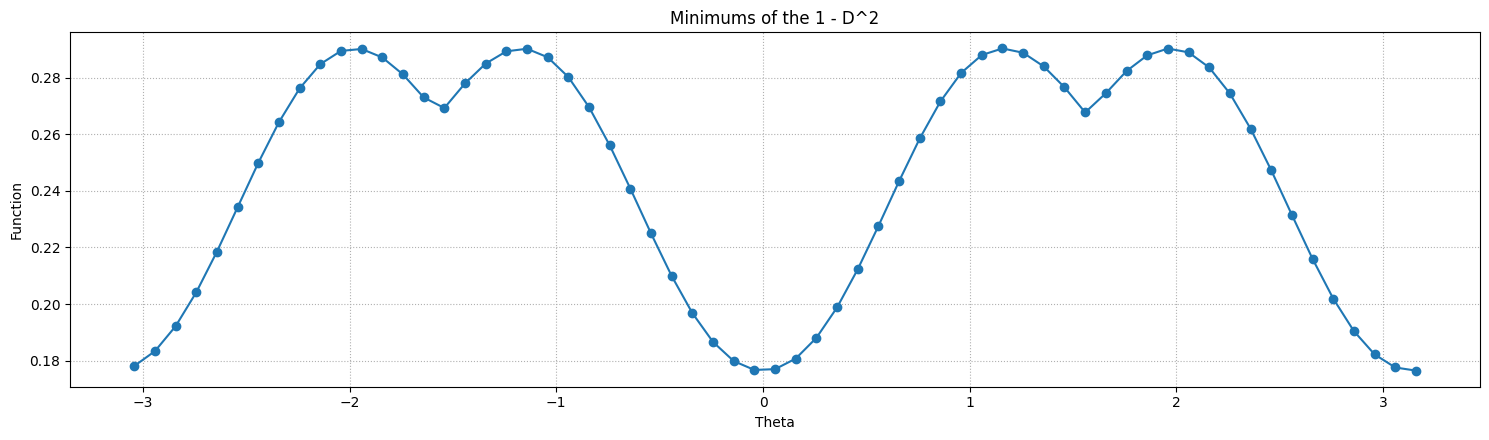

In [521]:
plt.figure(figsize=(15,4.5))
plt.plot(theta, y, marker='o')
plt.xlabel('Theta')
plt.ylabel('Function')
plt.title(f'Minimums of the 1 - D^2')
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

In [522]:
res_2 = minimize(
    func_to_minmize,
    x0=0.00001,
    args=(psi_1, deg_ground_basis,),
    method='SLSQP',
    options={'ftol': 1e-6, 'maxiter': 1000}
)

In [523]:
res_2

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: (0.1764205098309723+0j)
       x: [ 1.000e-05]
     nit: 1
     jac: [ 1.614e-05]
    nfev: 2
    njev: 1

In [524]:
psi_2 = min_output(res_2.x, psi_1, deg_ground_basis)

## Check

In [525]:
D_suqared_min = func_to_minmize(res_2.x, psi_1, deg_ground_basis)

In [526]:
D_suqared_min

np.complex128(0.1764205098309723+0j)

In [527]:
constr_ineq(C_opt, deg_ground_basis)

0.8235794902597144

In [528]:
if not(np.allclose(res_2.fun, D_suqared_min)):
    raise ValueError("The optimization doesn't match the graph.")

if not(res_2.fun.real > constr_ineq(C_opt, deg_ground_basis)):
    raise ValueError("The optimization step 2 is larger than step 1.")

ValueError: The optimization step 2 is larger than step 1.

# Produce new basis

In [529]:
D_2 = density_matrix_1(state**2, site, psi_2, 0)

eig_val_opt, opt_grd_basis = np.linalg.eigh(D_2)

index_opt = np.argsort(-eig_val_opt)
opt_grd_basis_orderd = opt_grd_basis[:, index_opt]

In [530]:
eig_val_opt[index_opt]

array([0.20914, 0.20914, 0.20913, 0.12275, 0.12275, 0.12275, 0.00145, 0.00145, 0.00145])

# Producing TF in new basis.

In [531]:
grouped = True

In [532]:
U, _ = bz.thermofield_change_of_basis(K)
U_kron = np.kron(opt_grd_basis_orderd, opt_grd_basis_orderd)
opt_grd_basis_orderd_kron = np.kron(opt_grd_basis_orderd, opt_grd_basis_orderd)

if grouped:

    U = np.eye(U.shape[0])
    U_kron = np.eye(U_kron.shape[0])

In [533]:
S = opt_grd_basis_orderd.T @ opt_grd_basis_orderd

In [534]:
S

array([[ 1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
       [-0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
       [ 0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
       [ 0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
       [-0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j,  1.+0.j]])

In [535]:
opt_grd_basis_orderd.real

array([[-0.52369, -0.73001,  0.43913,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ],
       [ 0.84351, -0.51655,  0.14722,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ],
       [ 0.11936,  0.4475 ,  0.88628, -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ],
       [-0.     ,  0.     , -0.     ,  0.52369,  0.73001, -0.43913, -0.     ,  0.     ,  0.     ],
       [-0.     , -0.     , -0.     , -0.84351,  0.51655, -0.14722,  0.     , -0.     , -0.     ],
       [ 0.     , -0.     ,  0.     , -0.11936, -0.4475 , -0.88628,  0.     ,  0.     , -0.     ],
       [-0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.52369, -0.73001, -0.43913],
       [ 0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     , -0.84351, -0.51655, -0.14722],
       [ 0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.11936,  0.4475 , -0.88628]])

***In opt basis***

In [536]:
K_opt_grd = opt_grd_basis_orderd.T.conj()@ U.T @ K_grouped @ U @ opt_grd_basis_orderd

V_opt_grd = opt_grd_basis_orderd_kron.conj().T @ U_kron.T @ V_grouped @ U_kron @ opt_grd_basis_orderd_kron

## Check

# Calculations

## TF Oz optimized

In [537]:
H_TF_os, K_TF_os, V_TF_os = hamiltonian_dense(state_2, site, 1, K_import=K_tilda, V_import=V_tilda, Import=True)

In [538]:
eig_val_TF_os_ED, eig_vec_TF_os_ED = np.linalg.eigh(H_TF_os)
ground_TF_os_ED = np.min(eig_val_TF_os_ED)

np.float64(-1.8341740563709767)

In [539]:
index_TF = np.argsort(eig_val_TF_os_ED)
deg_ground_basis_check = eig_vec_TF_os_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.23269201520264005


array([ 0.19245, -0.08577, -0.12005, -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     , -0.08577,  0.05378,  0.03033,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.12005,  0.03033,  0.116  ,  0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.16454,  0.     ,  0.1063 ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.01788, -0.     ,  0.     ,  0.00125,  0.     , -0.     , -0.     ,  0.     ,  0.1063 ,  0.     , -0.16454, -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.01155,  0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.00125, -0.     ,  0.     , -0.01788,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.01155, -0.08577,  0.05378,  0.03033,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.05378,  0.     , -0.07606, -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.

In [540]:
e_0_os = H_TF_os[0, 0]

In [541]:
E, t_1_max, t_2_max, E0_os = amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF_os, V_TF_os.reshape(state_2, state_2, state_2, state_2))
E

np.complex128(-1.8341740563709754+0j)

In [542]:
np.allclose(e_0_os, E0_os, atol=1e-20)

True

In [543]:
H_TF_opt, K_TF_opt, V_TF_opt = hamiltonian_dense(state_2, site, 1, K_import=K_opt_grd, V_import=V_opt_grd, Import=True)

In [544]:
eig_val_TF_opt_ED, eig_vec_TF_opt_ED = np.linalg.eigh(H_TF_opt)
ground_TF_opt_ED = np.min(eig_val_TF_opt_ED)
ground_TF_opt_ED

np.float64(-1.834174056370974)

In [545]:
index_TF = np.argsort(eig_val_TF_opt_ED)
deg_ground_basis_check = eig_vec_TF_opt_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.6641571896089185


array([ 0.66416, -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.4291 , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     , -0.04662, -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.

In [546]:
e_0 = H_TF_opt[0, 0]

In [547]:
amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF_opt, V_TF_opt.reshape(state_2, state_2, state_2, state_2))

(np.complex128(-1.8341740563709692+0j),
 np.float64(1.4311015804304853e-14),
 np.float64(0.6460785962755521),
 np.complex128(0.4148457774141994+0j))

In [548]:
index_TF = np.argmin(eig_val_TF_opt_ED)
psi_vec = eig_vec_TF[index_TF]

rho_site_0 = density_matrix_1(state_2, site, psi_vec, 0)

eig_va, eig_vc = np.linalg.eigh(-rho_site_0)
eig_va

array([-0.4411 , -0.43807, -0.12082, -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ])

In [549]:
H_TF, K_TF, V_TF = hamiltonian_dense(state_2, site, 1, K_import=K_grouped, V_import=V_grouped, Import=True)

In [550]:
eig_val_TF_ED, eig_vec_TF_ED = np.linalg.eigh(H_TF)
ground_TF_ED_vec = eig_vec_TF_ED[np.argmin(eig_val_TF_ED)]
ground_TF_ED = np.min(eig_val_TF_ED)
ground_TF_ED

np.float64(-1.8341740563709776)

In [551]:
index_TF = np.argsort(eig_val_TF_ED)
deg_ground_basis_check = eig_vec_TF_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.6641571896089182


array([ 0.66416,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.4291 ,  0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.04662, -0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.

In [552]:
amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF, V_TF.reshape(state_2, state_2, state_2, state_2))

(np.complex128(-1.8341740563709739+0j),
 np.float64(3.658483184595198e-16),
 np.float64(0.6460785962755522),
 np.complex128(0.4148457774141996+0j))

In [554]:
H_NO, K_NO, V_NO = hamiltonian_general_dense(state, site, g)

In [555]:
eig_val_ED, eig_vec_ED = np.linalg.eigh(H_NO)
ground_ED_vec = eig_vec_ED[:, np.argmin(eig_val_ED)]
ground_ED_vec_norm = ground_ED_vec / ground_ED_vec[0]
ground_ED = np.min(eig_val_ED)
ground_ED

np.float64(-1.8341740563709745)

In [556]:
amplitute_energy(site, state, g, ground_ED_vec_norm, True, K_NO, V_NO.reshape(state, state, state, state))

(np.complex128(-1.8341740563709734+0j),
 np.float64(4.847718012822851e-15),
 np.float64(0.6460785962755521),
 np.complex128(0.4148457774141996+0j))

***Imag. Time propagation***

In [557]:
time_opt, energy_TD_CCC_opt, one_max_TDCC_opt, two_max_TDCC_opt = int_slow(site, state_2, 1, t_init=0, t_final=10, nof_points=10000, import_K_V_TF=True, K_import=K_opt_grd, V_import=V_opt_grd.reshape(state_2, state_2, state_2, state_2))

In [558]:
time_TF, energy_TD_TF_CCC, one_max_TD_TF_CC, two_max_TD_TF_CC = int_slow(site, state_2, 1, t_init=0, t_final=10, nof_points=10000, import_K_V_TF=True, K_import=K_tilda, V_import=V_tilda.reshape(state_2, state_2, state_2, state_2))

In [559]:
time, energy_TD_CCC, one_max_TDCC, two_max_TDCC = int_slow(site, state, 1, t_init=0, t_final=10, nof_points=10000, import_K_V_TF=True, K_import=K_NO, V_import=V_NO.reshape(state, state, state, state))

In [ ]:
time, energy_TD_CCC, one_max_TDCC, two_max_TDCC = int_slow(site, state, 1, t_init=0, t_final=10, nof_points=10000, import_K_V_TF=True, K_import=K_NO, V_import=V_NO.reshape(state, state, state, state))

***CCC***

In [560]:
# energy_CCC, t_1, t_2 = t_periodic(site, state_2, 1, K_import=K_opt_grd, V_import=V_opt_grd.reshape(state_2, state_2, state_2, state_2), Import=True)

In [561]:
# one_max, two_max, energy_CCC, t_1, t_2 = t_periodic(site, state_2, 1, K_import=K_tilda, V_import=V_tilda.reshape(state_2, state_2, state_2, state_2), Import=True)

In [562]:
# one_max, two_max, energy_CCC, t_1, t_2 = t_periodic(site, state, g, NO=True)

# Analysis

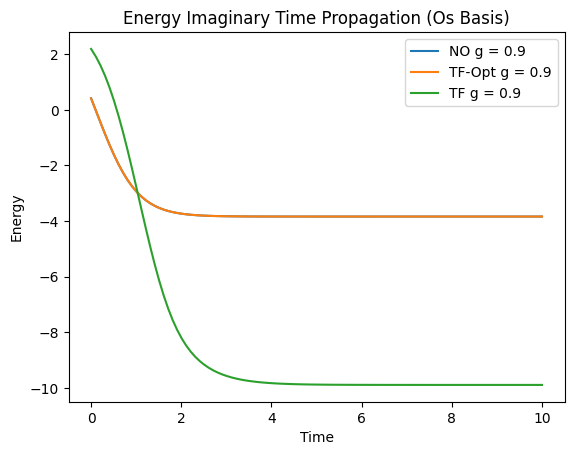

NO (-3.839842254791602+0j)
TF-Opt (-3.8398422547915896+0j)
TF (-9.896575859835227+0j)
Exact:  -1.8341740563709745


In [563]:
plt.plot(time, -energy_TD_CCC, label=f"NO g = {g}")
plt.plot(time_opt, -energy_TD_CCC_opt, label=f"TF-Opt g = {g}")
plt.plot(time_TF, -energy_TD_TF_CCC, label=f"TF g = {g}")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

print("NO", -energy_TD_CCC[-1])
print("TF-Opt", -energy_TD_CCC_opt[-1])
print("TF", -energy_TD_TF_CCC[-1])
print("Exact: ", ground_ED)

In [564]:
e_0_os

np.complex128(2.19069675246064+0j)

In [565]:
ground_ED

np.float64(-1.8341740563709745)

In [566]:
ground_TF_os_ED

np.float64(-1.8341740563709767)

In [567]:
ground_TF_ED

np.float64(-1.8341740563709776)

In [568]:
ground_TF_opt_ED

np.float64(-1.834174056370974)